# Road Lane Lines Curves Detection

This project is inspired from Udacity's project ["Finding Lane Lines on the Road"](https://github.com/udacity/CarND-LaneLines-P1) part of Self-Driving Car Engineer ND.


In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
import numpy as np
import cv2
%matplotlib inline

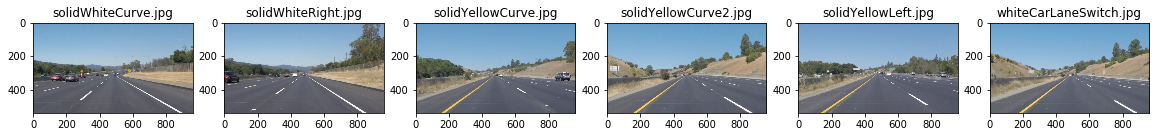

In [2]:
#checking the images within the test images folder.
images = []
names = []

for i in glob.glob('test_images/*.jpg'):
    images.append(mpimg.imread(i))

for filename in glob.glob('test_images/*.jpg'):
    names.append(os.path.basename(os.path.normpath(filename)))

plt.figure(figsize=(20,5))
columns = len(images)
for t, (name, image) in enumerate(zip(names, images)):
    plt.subplot(len(images) / columns +1, columns, t+1)
    plt.title(name)
    plt.imshow(image)

### Let's focusing on the 1st solidWhiteCurve

(540, 960, 3)


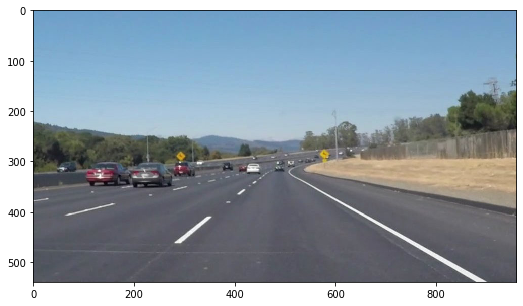

In [3]:
plt.figure(figsize=(15,5))
fimage = mpimg.imread('test_images/solidWhiteCurve.jpg')
print(fimage.shape)
plt.imshow(fimage)

### Grayscale transform to reduce noise (here color)

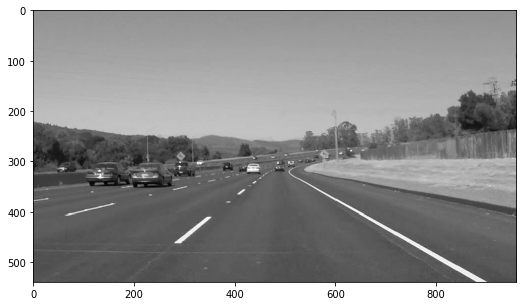

In [4]:
plt.figure(figsize=(10,5))

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
imgr = grayscale(fimage)
plt.imshow(imgr, cmap='gray')

### Canny for edge detection
**This the mandatory contour extraction step.**<br>
Edges with intensity gradient more than high_threshold are edges!<br>
Edges with intensity gradient below than low_threshold are non-edges!<br>
Edges with intensity gradient in between low and high threshold are classified edges or non-edges based
on their connectivity with the classified edges.

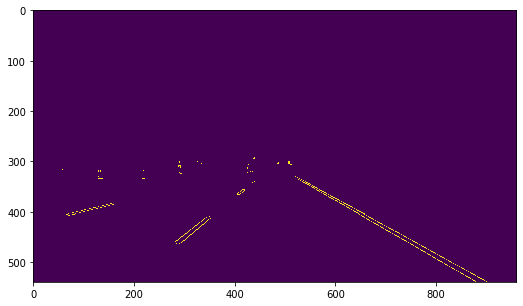

In [5]:
plt.figure(figsize=(10,5))

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

imcann = canny(imgr, 385, 550)
plt.imshow(imcann)

### Gaussian_Blur to remove high frequency content (noise, edges).
This actually is smoothing the input image.

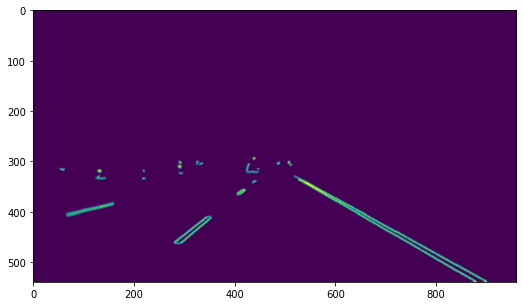

In [6]:
plt.figure(figsize=(10,5))

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

imgauss = gaussian_blur(imcann, 7)
plt.imshow(imgauss)

### Region_of_interest
1. Mask step: defining a blank mask
2. Filling step: filling up the area with the data we want
3. Mixing step: bitwise_and the input image with the transormed image

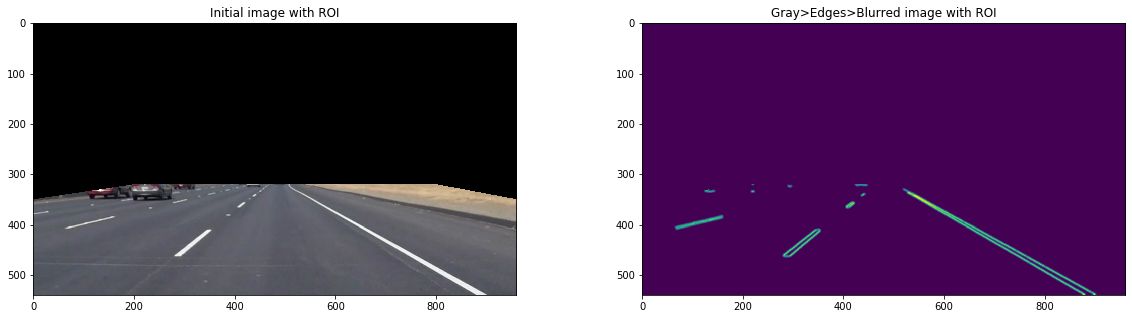

In [7]:
def roi(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    # Mask step
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # in our case 3, recall the shape of the image (540, 960, 3)
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    # Filling step: filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Mixing step: returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# recall the shape of the image (540, 960, 3)
vertices = np.array([[0,540],[0,350], [200,320], [800,320], [960,350], [960,540]], np.int32)

imroi_1 = roi(fimage, [vertices])
imroi_2 = roi(imgauss, [vertices])

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title("Initial image with ROI")
plt.imshow(imroi_1)
plt.subplot(1,2,2)
plt.title("Gray>Edges>Blurred image with ROI")
plt.imshow(imroi_2)

### Hough Line transformation to detect shape
Actually, for each pixel within the contour, the algorithm is considering all the possible lines passing through the pixel.<br>
Hough Line uses the representation of line in the parametric form with (rho, theta).
<br><br>
But first, **we need to Draw lines.**

In [19]:
def draw_lines(img, lines, color=[0, 250, 154], thickness=2):
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [20]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

rho = 4 # max rho is the diagonal of the picture
theta = np.pi/180
threshold = 180
min_line_len = 10
max_line_gap = 20
imhl = hough_lines(imroi_2,rho, theta, threshold, min_line_len, max_line_gap)

plt.figure(figsize=(20,5))
plt.imshow(imhl)

# WIP